# ML HW1 | Supervised Learning | Decision Trees
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Note: I partially took this course in Fall of 2020 and dropped the course. Some content may trigget plagiarism tests.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import time

## Set directory

In [2]:
directory = "/Users/mikepecorino/Documents/machine_learning/HW1/"

## Load inputs

In [3]:
data_all = pd.read_csv(directory + "sensor_all.csv")

## Define features and response variable

### Features list

In [4]:
features = data_all.columns[data_all.columns.isin(["subject", "activity_raw", "activity", "tag", "fold", "response_prop"]) == False]


### Features data

In [5]:
data_all_features = data_all[features]
train_features = data_all[features][data_all["tag"] == "train"]
valid_features = data_all[features][data_all["tag"] == "valid"]
test_features = data_all[features][data_all["tag"] == "test"]

### Response variable

In [6]:
response = "activity"

### Response data

In [7]:
data_all_response = data_all[response]
train_response = data_all[response][data_all["tag"] == "train"]
valid_response = data_all[response][data_all["tag"] == "valid"]
test_response = data_all[response][data_all["tag"] == "test"]

## Decision Tree

### Initial model using default values

In [8]:
decision_tree_model = DecisionTreeClassifier(criterion = "entropy",
                                             splitter = "best",
                                             max_depth = None,
                                             min_samples_split = 2,
                                             min_samples_leaf = 1,
                                             min_weight_fraction_leaf = 0.0,
                                             max_features = None,
                                             random_state = 28,
                                             max_leaf_nodes = None,
                                             min_impurity_decrease = 0.0,
                                             class_weight = None,
                                             ccp_alpha = 0.0)

decision_tree_model.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model.score(valid_features, valid_response))

Decision tree accuracy on training data:  1.0
Decision tree accuracy on validation data:  0.9492063492063492


### Cost complexity pruning path
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

#### Get the CCP

In [9]:
path = decision_tree_model.cost_complexity_pruning_path(train_features, train_response)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_df = pd.DataFrame(columns = ['ccp_alphas', 'impurities'])
for i in range(0,len(ccp_alphas)):
    ccp_df = ccp_df.append({'ccp_alphas': ccp_alphas[i].round(6),
                            'impurities': impurities[i].round(3)},
                          ignore_index = True)

ccp_df_unique = ccp_df.drop_duplicates()
ccp_alphas = np.array(ccp_df_unique["ccp_alphas"])
impurities = np.array(ccp_df_unique["impurities"])

#### Plot the CCP

Text(0.5, 1.0, 'Total impurity vs effective alpha for training data')

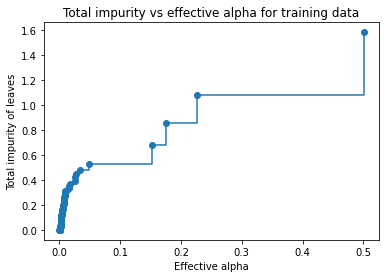

In [10]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = 'o', drawstyle = "steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training data")

### Train a decision tree for each ccp_alpha and evaluate on cross-validation

In [11]:
data_cv = data_all[data_all["tag"].isin(["train", "valid"])]
folds = set(data_cv["fold"])
folds

{1, 2, 3, 4, 5}

In [12]:
#Initialize an empty list of models
decision_tree_ccps = []
#Initialize an empty data frame for recording results
cross_validation_results = pd.DataFrame(columns = ["iter_counter",
                                                   "ccp_alpha",
                                                   "fold",
                                                   "in_fold_score",
                                                   "out_fold_score"])

#Start an iteration counter
iter_counter = 0

#For each ccp
for ccp_alpha in ccp_alphas:
    
    #Increment the counter
    iter_counter = iter_counter + 1
    
    #For each fold
    for fold in folds:
        
        #Debugging
        #ccp_alpha = .0004
        #fold = 1
        
        #Output message
        print("iter_counter:", iter_counter,
              "| fold:", fold,
              "| ccp_alpha:", ccp_alpha,
              "| impurity:", impurities[iter_counter - 1])
        
        #Train on 4 out of 5 folds
        train_fold_features = data_cv[data_cv["fold"] != fold][features]
        train_fold_response = data_cv[data_cv["fold"] != fold][response]
        
        #Test on the current fold
        test_fold_features = data_cv[data_cv["fold"] == fold][features]
        test_fold_response = data_cv[data_cv["fold"] == fold][response]

        #Get the decision tree object
        decision_tree_ccp = DecisionTreeClassifier(criterion = "entropy",
                                                   splitter = "best",
                                                   max_depth = None,
                                                   min_samples_split = 2,
                                                   min_samples_leaf = 1,
                                                   min_weight_fraction_leaf = 0.0,
                                                   max_features = None,
                                                   random_state = 28,
                                                   max_leaf_nodes = None,
                                                   min_impurity_decrease = 0.0,
                                                   class_weight = None,
                                                   ccp_alpha = ccp_alpha)
        
        #Fit the model
        decision_tree_ccp.fit(train_fold_features, train_fold_response)
        #Append the model to the list of models
        decision_tree_ccps.append(decision_tree_ccp)
        
        #Evaluate the model
        #In fold
        in_fold_score = decision_tree_ccp.score(train_fold_features, train_fold_response)
        #Out of fold
        out_fold_score = decision_tree_ccp.score(test_fold_features, test_fold_response)
        
        #Add to results list
        cross_validation_results = cross_validation_results.append({"iter_counter": iter_counter,
                                                                    "ccp_alpha": ccp_alpha,
                                                                    "fold": fold,
                                                                    "in_fold_score": in_fold_score,
                                                                    "out_fold_score": out_fold_score},
                                                                 ignore_index = True)

iter_counter: 1 | fold: 1 | ccp_alpha: 0.0 | impurity: 0.0
iter_counter: 1 | fold: 2 | ccp_alpha: 0.0 | impurity: 0.0
iter_counter: 1 | fold: 3 | ccp_alpha: 0.0 | impurity: 0.0
iter_counter: 1 | fold: 4 | ccp_alpha: 0.0 | impurity: 0.0
iter_counter: 1 | fold: 5 | ccp_alpha: 0.0 | impurity: 0.0
iter_counter: 2 | fold: 1 | ccp_alpha: 0.000389 | impurity: 0.0
iter_counter: 2 | fold: 2 | ccp_alpha: 0.000389 | impurity: 0.0
iter_counter: 2 | fold: 3 | ccp_alpha: 0.000389 | impurity: 0.0
iter_counter: 2 | fold: 4 | ccp_alpha: 0.000389 | impurity: 0.0
iter_counter: 2 | fold: 5 | ccp_alpha: 0.000389 | impurity: 0.0
iter_counter: 3 | fold: 1 | ccp_alpha: 0.000389 | impurity: 0.001
iter_counter: 3 | fold: 2 | ccp_alpha: 0.000389 | impurity: 0.001
iter_counter: 3 | fold: 3 | ccp_alpha: 0.000389 | impurity: 0.001
iter_counter: 3 | fold: 4 | ccp_alpha: 0.000389 | impurity: 0.001
iter_counter: 3 | fold: 5 | ccp_alpha: 0.000389 | impurity: 0.001
iter_counter: 4 | fold: 1 | ccp_alpha: 0.000535 | impur

iter_counter: 26 | fold: 1 | ccp_alpha: 0.001703 | impurity: 0.026
iter_counter: 26 | fold: 2 | ccp_alpha: 0.001703 | impurity: 0.026
iter_counter: 26 | fold: 3 | ccp_alpha: 0.001703 | impurity: 0.026
iter_counter: 26 | fold: 4 | ccp_alpha: 0.001703 | impurity: 0.026
iter_counter: 26 | fold: 5 | ccp_alpha: 0.001703 | impurity: 0.026
iter_counter: 27 | fold: 1 | ccp_alpha: 0.001733 | impurity: 0.027
iter_counter: 27 | fold: 2 | ccp_alpha: 0.001733 | impurity: 0.027
iter_counter: 27 | fold: 3 | ccp_alpha: 0.001733 | impurity: 0.027
iter_counter: 27 | fold: 4 | ccp_alpha: 0.001733 | impurity: 0.027
iter_counter: 27 | fold: 5 | ccp_alpha: 0.001733 | impurity: 0.027
iter_counter: 28 | fold: 1 | ccp_alpha: 0.001762 | impurity: 0.029
iter_counter: 28 | fold: 2 | ccp_alpha: 0.001762 | impurity: 0.029
iter_counter: 28 | fold: 3 | ccp_alpha: 0.001762 | impurity: 0.029
iter_counter: 28 | fold: 4 | ccp_alpha: 0.001762 | impurity: 0.029
iter_counter: 28 | fold: 5 | ccp_alpha: 0.001762 | impurity: 0

iter_counter: 50 | fold: 4 | ccp_alpha: 0.002759 | impurity: 0.085
iter_counter: 50 | fold: 5 | ccp_alpha: 0.002759 | impurity: 0.085
iter_counter: 51 | fold: 1 | ccp_alpha: 0.002796 | impurity: 0.09
iter_counter: 51 | fold: 2 | ccp_alpha: 0.002796 | impurity: 0.09
iter_counter: 51 | fold: 3 | ccp_alpha: 0.002796 | impurity: 0.09
iter_counter: 51 | fold: 4 | ccp_alpha: 0.002796 | impurity: 0.09
iter_counter: 51 | fold: 5 | ccp_alpha: 0.002796 | impurity: 0.09
iter_counter: 52 | fold: 1 | ccp_alpha: 0.002837 | impurity: 0.093
iter_counter: 52 | fold: 2 | ccp_alpha: 0.002837 | impurity: 0.093
iter_counter: 52 | fold: 3 | ccp_alpha: 0.002837 | impurity: 0.093
iter_counter: 52 | fold: 4 | ccp_alpha: 0.002837 | impurity: 0.093
iter_counter: 52 | fold: 5 | ccp_alpha: 0.002837 | impurity: 0.093
iter_counter: 53 | fold: 1 | ccp_alpha: 0.002876 | impurity: 0.096
iter_counter: 53 | fold: 2 | ccp_alpha: 0.002876 | impurity: 0.096
iter_counter: 53 | fold: 3 | ccp_alpha: 0.002876 | impurity: 0.096


iter_counter: 75 | fold: 2 | ccp_alpha: 0.006782 | impurity: 0.205
iter_counter: 75 | fold: 3 | ccp_alpha: 0.006782 | impurity: 0.205
iter_counter: 75 | fold: 4 | ccp_alpha: 0.006782 | impurity: 0.205
iter_counter: 75 | fold: 5 | ccp_alpha: 0.006782 | impurity: 0.205
iter_counter: 76 | fold: 1 | ccp_alpha: 0.006843 | impurity: 0.218
iter_counter: 76 | fold: 2 | ccp_alpha: 0.006843 | impurity: 0.218
iter_counter: 76 | fold: 3 | ccp_alpha: 0.006843 | impurity: 0.218
iter_counter: 76 | fold: 4 | ccp_alpha: 0.006843 | impurity: 0.218
iter_counter: 76 | fold: 5 | ccp_alpha: 0.006843 | impurity: 0.218
iter_counter: 77 | fold: 1 | ccp_alpha: 0.007119 | impurity: 0.226
iter_counter: 77 | fold: 2 | ccp_alpha: 0.007119 | impurity: 0.226
iter_counter: 77 | fold: 3 | ccp_alpha: 0.007119 | impurity: 0.226
iter_counter: 77 | fold: 4 | ccp_alpha: 0.007119 | impurity: 0.226
iter_counter: 77 | fold: 5 | ccp_alpha: 0.007119 | impurity: 0.226
iter_counter: 78 | fold: 1 | ccp_alpha: 0.007156 | impurity: 0

iter_counter: 99 | fold: 5 | ccp_alpha: 0.225876 | impurity: 1.084
iter_counter: 100 | fold: 1 | ccp_alpha: 0.500787 | impurity: 1.585
iter_counter: 100 | fold: 2 | ccp_alpha: 0.500787 | impurity: 1.585
iter_counter: 100 | fold: 3 | ccp_alpha: 0.500787 | impurity: 1.585
iter_counter: 100 | fold: 4 | ccp_alpha: 0.500787 | impurity: 1.585
iter_counter: 100 | fold: 5 | ccp_alpha: 0.500787 | impurity: 1.585
iter_counter: 101 | fold: 1 | ccp_alpha: 0.99367 | impurity: 2.579
iter_counter: 101 | fold: 2 | ccp_alpha: 0.99367 | impurity: 2.579
iter_counter: 101 | fold: 3 | ccp_alpha: 0.99367 | impurity: 2.579
iter_counter: 101 | fold: 4 | ccp_alpha: 0.99367 | impurity: 2.579
iter_counter: 101 | fold: 5 | ccp_alpha: 0.99367 | impurity: 2.579


In [13]:
print("Number of nodes in the last tree is:", decision_tree_ccps[-1].tree_.node_count,
      "with ccp_alpha:", ccp_alphas[-1])

Number of nodes in the last tree is: 1 with ccp_alpha: 0.99367


## Output

In [14]:
cross_validation_results.to_csv(directory + "sensor_decision_tree_cv.csv", index = False)
cross_validation_results

,iter_counter,ccp_alpha,fold,in_fold_score,out_fold_score
0,1.0,0.00000,1.0,1.000000,0.952285
1,1.0,0.00000,2.0,1.000000,0.935661
2,1.0,0.00000,3.0,1.000000,0.950908
3,1.0,0.00000,4.0,1.000000,0.945742
4,1.0,0.00000,5.0,1.000000,0.939726
...,...,...,...,...,...
500,101.0,0.99367,1.0,0.189973,0.196909
501,101.0,0.99367,2.0,0.192667,0.186174
502,101.0,0.99367,3.0,0.190963,0.193006
503,101.0,0.99367,4.0,0.189620,0.198489


### Get the cross-validation summary

In [15]:
cross_validation_results = pd.read_csv(directory + "sensor_decision_tree_cv.csv")
cross_validation_results

,iter_counter,ccp_alpha,fold,in_fold_score,out_fold_score
0,1.0,0.00000,1.0,1.000000,0.952285
1,1.0,0.00000,2.0,1.000000,0.935661
2,1.0,0.00000,3.0,1.000000,0.950908
3,1.0,0.00000,4.0,1.000000,0.945742
4,1.0,0.00000,5.0,1.000000,0.939726
...,...,...,...,...,...
500,101.0,0.99367,1.0,0.189973,0.196909
501,101.0,0.99367,2.0,0.192667,0.186174
502,101.0,0.99367,3.0,0.190963,0.193006
503,101.0,0.99367,4.0,0.189620,0.198489


### Learning curve

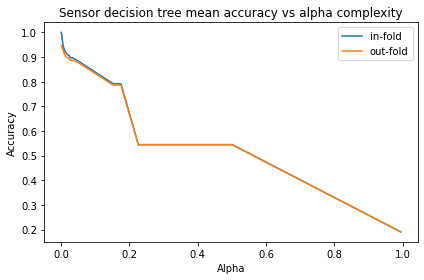

In [17]:
in_fold_c_summary = cross_validation_results.groupby("ccp_alpha")["in_fold_score"].agg(["mean"]).sort_values(by = ["mean"], ascending = False)
out_fold_c_summary = cross_validation_results.groupby("ccp_alpha")["out_fold_score"].agg(["mean"]).sort_values(by = ["mean"], ascending = False)
fig, ax = plt.subplots()

ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
#ax.set_xlim(.0, .007)
ax.set_title("Sensor decision tree mean accuracy vs alpha complexity")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        in_fold_c_summary["mean"],
        label = "in-fold")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        out_fold_c_summary["mean"],
        label = "out-fold")
ax.legend()

fig.tight_layout()

### Train a final model with the optimal complexity

In [18]:
#Get the ccp alpha with the maximum out of fold score
ccp_alpha_opt = out_fold_c_summary.index[np.argmax(out_fold_c_summary["mean"])]
decision_tree_model_final = DecisionTreeClassifier(criterion = "entropy",
                                                     splitter = "best",
                                                     max_depth = None,
                                                     min_samples_split = 2,
                                                     min_samples_leaf = 1,
                                                     min_weight_fraction_leaf = 0.0,
                                                     max_features = None,
                                                     random_state = 28,
                                                     max_leaf_nodes = None,
                                                     min_impurity_decrease = 0.0,
                                                     class_weight = None,
                                                     ccp_alpha = ccp_alpha_opt)

decision_tree_model_final.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model_final.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model_final.score(valid_features, valid_response))
print("Decision tree accuracy on test data: ",
      decision_tree_model_final.score(test_features, test_response))

Decision tree accuracy on training data:  0.9943656498931417
Decision tree accuracy on validation data:  0.9464852607709751
Decision tree accuracy on test data:  0.8571428571428571


In [19]:
train_scores = [decision_tree_ccp.score(train_features, train_response) for decision_tree_ccp in decision_tree_ccps]
valid_scores = [decision_tree_ccp.score(valid_features, valid_response) for decision_tree_ccp in decision_tree_ccps]
test_scores = [decision_tree_ccp.score(test_features, test_response) for decision_tree_ccp in decision_tree_ccps]

In [20]:
print(max(train_scores))
print(max(valid_scores))
print(max(test_scores))

0.9906741791334758
0.9909297052154195
0.8700373260943333


### Function of training size

In [21]:
decision_tree_train_sizes = []
decision_tree_train_size_train_scores = []
decision_tree_train_size_test_scores = []
decision_tree_train_size_train_time = []
decision_tree_train_size_score_time = []

#Start a counter
iter_counter = 0

#Training set sizes
train_sizes = np.linspace(.05,.95, 19)

#For each training set size
for train_size in train_sizes:
    
    #Increment the counter
    iter_counter = iter_counter + 1
    
    #Output m essage
    print("iter_counter:", iter_counter,
          "| train size:", train_size)
    
    (train_features_train_size, test_features_train_size,
    train_response_train_size, test_response_train_size) = train_test_split(data_all_features,
                                                                            data_all_response,
                                                                            train_size = train_size,
                                                                            random_state = 28)
    
    #Get the decision tree object
    decision_tree_train_size = DecisionTreeClassifier(criterion = "entropy",
                                                      splitter = "best",
                                                      max_depth = None,
                                                      min_samples_split = 2,
                                                      min_samples_leaf = 1,
                                                      min_weight_fraction_leaf = 0.0,
                                                      max_features = None,
                                                      random_state = 28,
                                                      max_leaf_nodes = None,
                                                      min_impurity_decrease = 0.0,
                                                      class_weight = None,
                                                      ccp_alpha = ccp_alpha_opt)
    
    #Start the timer
    start = time.time()
    #Fit the model
    decision_tree_train_size.fit(train_features_train_size, train_response_train_size)
    #End the timer
    end = time.time()
    #Add to list of training times
    decision_tree_train_size_train_time.append(end - start)

    decision_tree_train_sizes.append(decision_tree_train_size)
    
    #Start the scoring timer
    start = time.time()
    #Score the model
    decision_tree_train_size_train_scores.append(decision_tree_train_size.score(train_features_train_size, train_response_train_size)) 
    #End the timer
    end = time.time()
    #Add to the list of prediction times
    decision_tree_train_size_score_time.append(end - start)

    #Add to the scores list
    decision_tree_train_size_test_scores.append(decision_tree_train_size.score(test_features_train_size, test_response_train_size))
    

iter_counter: 1 | train size: 0.05
iter_counter: 2 | train size: 0.1
iter_counter: 3 | train size: 0.15
iter_counter: 4 | train size: 0.2
iter_counter: 5 | train size: 0.25
iter_counter: 6 | train size: 0.3
iter_counter: 7 | train size: 0.35
iter_counter: 8 | train size: 0.39999999999999997
iter_counter: 9 | train size: 0.44999999999999996
iter_counter: 10 | train size: 0.49999999999999994
iter_counter: 11 | train size: 0.5499999999999999
iter_counter: 12 | train size: 0.6
iter_counter: 13 | train size: 0.65
iter_counter: 14 | train size: 0.7
iter_counter: 15 | train size: 0.75
iter_counter: 16 | train size: 0.7999999999999999
iter_counter: 17 | train size: 0.85
iter_counter: 18 | train size: 0.9
iter_counter: 19 | train size: 0.95


### Plotting the learning curve by training size, for a fixed complexity

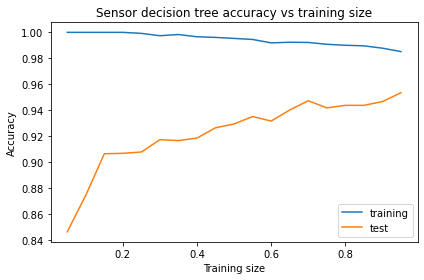

In [22]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Accuracy")
ax.set_title("Sensor decision tree accuracy vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_scores, label = "training",
        #drawstyle = "steps-post"
       )
ax.plot(train_sizes, decision_tree_train_size_test_scores, label = "test",
        #drawstyle = "steps-post"
       )
ax.legend()

fig.tight_layout()

###  Plotting the model fitting time as a function of the training size

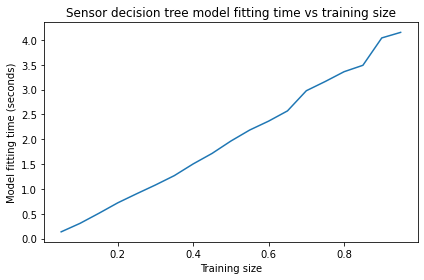

In [23]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Model fitting time (seconds)")
ax.set_title("Sensor decision tree model fitting time vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()

### Plotting the model scoring time as a function of the training size

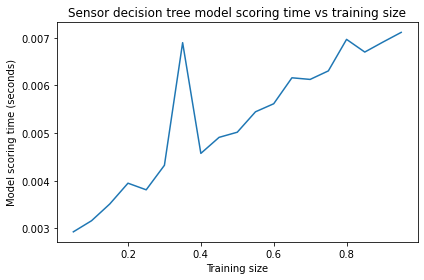

In [24]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Model scoring time (seconds)")
ax.set_title("Sensor decision tree model scoring time vs training size")
ax.plot(train_sizes, decision_tree_train_size_score_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()

In [ ]:
Yes 